In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from matplotlib.colors import ListedColormap
import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)

from scipy.sparse import diags, coo_matrix
from scipy import sparse
import jax.numpy as jnp

import pickle
import jax
from jax import lax, vmap, jit
import jax.random as random
from jax.experimental import sparse

#add path where to save figures


In [2]:
savefig_args = {
    'transparent': True,
    'format': 'pdf',
    'dpi': 300,
    'facecolor': 'none',
    'bbox_inches': 'tight',
    'pad_inches': 0
}

In [3]:

def generate_laplacian(N, M, conduction_block_threshold, sparse_matrix=False, seed=0):
    num_nodes = N * M
    adj_rows = []
    adj_cols = []
    adj_data = []

    # Generate random conduction blocks
    np.random.seed(seed)
    conduction_blocks = np.random.rand(N, M) < conduction_block_threshold


    # Function to map grid (i, j) to a single node index
    def node_index(i, j):
        return i * M + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, .5),     # up
        (1, 0, .5),      # down
        (0, -1, .5),     # left
        (0, 1, .5),      # right
        (-1, -1, .25),   # top-left
        (-1, 1, .25),    # top-right
        (1, -1, .25),    # bottom-left
        (1, 1, .25)      # bottom-right
    ]
    
    # Build adjacency structure excluding conduction blocks
    indices = np.array([[i, j] for i in range(N) for j in range(M)])
    idx = node_index(indices[:, 0], indices[:, 1])

    for di, dj, weight in neighbors:
        ni = indices[:, 0] + di
        nj = indices[:, 1] + dj

    # Step 1: Filter for in-bounds neighbors
        in_bounds = (ni >= 0) & (ni < N) & (nj >= 0) & (nj < M)
    
    # Step 2: Find valid indices (in-bounds) to avoid shape mismatches
        valid_indices = np.where(in_bounds)[0]
        ni_valid = ni[valid_indices]
        nj_valid = nj[valid_indices]

    # Step 3: Apply conduction block exclusion on the filtered indices
        valid_conduction = ~conduction_blocks[ni_valid, nj_valid]
        valid_node = ~conduction_blocks[indices[valid_indices, 0], indices[valid_indices, 1]]
        valid = valid_conduction & valid_node

    # Step 4: Append data for fully valid connections
        adj_rows.extend(idx[valid_indices][valid])
        adj_cols.extend(node_index(ni_valid[valid], nj_valid[valid]))
        adj_data.extend([weight] * int(np.sum(valid)))


    # Create adjacency and degree matrices
    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Construct Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix


    if sparse_matrix:

        return sparse.BCSR.from_scipy_sparse(laplacian_matrix), jnp.array(conduction_blocks)
    
    else:
        return laplacian_matrix.todense(), conduction_blocks



In [4]:

def FHN_step(u, v, N, a, b, e, Du, sigma, L, key, delta_t):
    '''
    Perform a single step of the noisy FitzHugh-Nagumo model.
    Parameters:
    - u: state variable u
    - v: state variable v
    - N: number of nodes
    - a: parameter a
    - b: parameter b
    - e: parameter e giving the timescale separation between u and v
    - Du: Diffusion coefficient
    - sigma: noise intensity
    - L: Laplacian matrix
    - key: random key for noise generation
    - delta_t: time step
    Returns:
    - u_new: updated state variable u
    - v_new: updated state variable v
    '''
    # Generate Gaussian noise for each element of h
    noise = random.normal(key, u.shape)
    
    du = a * u * (u - b) * (1 - u) - Du * (L @ u) - v 
    dv = e * (u - v)
    u_new = u + du * delta_t + jnp.sqrt(delta_t * sigma**2) * noise
    v_new = v + dv * delta_t

    return u_new, v_new

def run_simulation(N, y0='wave', a=3, b=0.05, e=1e-2, Du=0.04, L=None, c1=None, sigma=0.0001, stimulus_time=1000, delta_t=0.1, total_time=3000.0, Nconf=3000, key=random.PRNGKey(2)):
    indices = jnp.where((jnp.arange(N) % 200 == 0) & (c1.flatten() == 0))[0]
    if y0 == 'wave':
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        y0 = y0.at[indices].set(0.1)

    # Calculate the number of steps based on the total time and delta_t
    num_steps = int(total_time / delta_t)
    save_interval = num_steps // Nconf
    
    # Initialize state variables
    u = y0[:N]
    v = y0[N:]

    def scan_fn(carry, step):
        u, v, key, save_counter, u_saved, v_saved = carry
        key, subkey = random.split(key)
        
        # Apply stimulus to the specified indices
        u = jax.lax.cond((step > 0) & (step % int(stimulus_time / delta_t) == 0),
                          lambda u: u.at[indices].add(0.1),
                          lambda u: u,
                          u)

        u, v = FHN_step(u, v, N, a, b, e, Du, sigma, L, subkey, delta_t)
        
        # Save the configuration at the specified intervals
        save_counter = save_counter + 1
        u_saved = jax.lax.cond(save_counter % save_interval == 0,
                               lambda u_saved: u_saved.at[save_counter // save_interval - 1].set(u),
                               lambda u_saved: u_saved,
                               u_saved)
        v_saved = jax.lax.cond(save_counter % save_interval == 0,
                               lambda v_saved: v_saved.at[save_counter // save_interval - 1].set(v),
                               lambda v_saved: v_saved,
                               v_saved)
        
        return (u, v, key, save_counter, u_saved, v_saved), (u, v)

    # Preallocate arrays for saved configurations
    u_saved = jnp.zeros((Nconf, N), dtype=jnp.float32)
    v_saved = jnp.zeros((Nconf, N), dtype=jnp.float32)
    
    # Create a range of steps
    steps = jnp.arange(num_steps)
    
    # Run the scan function
    carry = (u, v, key, 0, u_saved, v_saved)
    carry, _ = lax.scan(scan_fn, carry, steps)

    u_saved = carry[4]
    v_saved = carry[5]

    return u_saved, v_saved

## Actual simulations

In [5]:
#here number of lattice points is the same as in the order parameter simulation, could be decreased
N_y=200
N_x=200
N=N_x*N_y

# healthy laplacian
L1, c1 = generate_laplacian(N_x,N_y,0, seed=1000, sparse_matrix=True)

#arrhythmic laplacian
L2,c2=generate_laplacian(N_x,N_y,0.45, seed=1000, sparse_matrix=True)

In [12]:
# here the parameters are the one that we have used for the actual order parameter simulations. 
# To change how ofter the stimulus is applied, change the stimulus_time 
# To change the total time of the simulation, change the total_time 


#healthy heart simulation
u_sol_health, v_sol_health = run_simulation(N=N, sigma=0.0001,L=L1, c1=c1, key=random.PRNGKey(2),delta_t=0.1, total_time=5200, stimulus_time=1300, Nconf=5200)
#Arrhythmia simulation
u_sol_arr, v_sol_arr = run_simulation(N=N, sigma=0.0001,L=L2, c1=c2, key=random.PRNGKey(2),delta_t=0.1, total_time=5200, stimulus_time=1300, Nconf=5200)
u_sol_health=u_sol_health.T
u_sol_arr=u_sol_arr.T

#binarize the results for the raster plot and reshape
u_sol_health_bin= jnp.where(u_sol_health > 0.08, 1, jnp.nan)
u_sol_arr_bin= jnp.where(u_sol_arr > 0.08, 1, jnp.nan)
u_sol_health_bin=u_sol_health_bin.reshape(N_y,N_x,-1)
u_sol_arr_bin=u_sol_arr_bin.reshape(N_y,N_x,-1)
#probably advisable to store the results somewhere :)

## Raster Plots

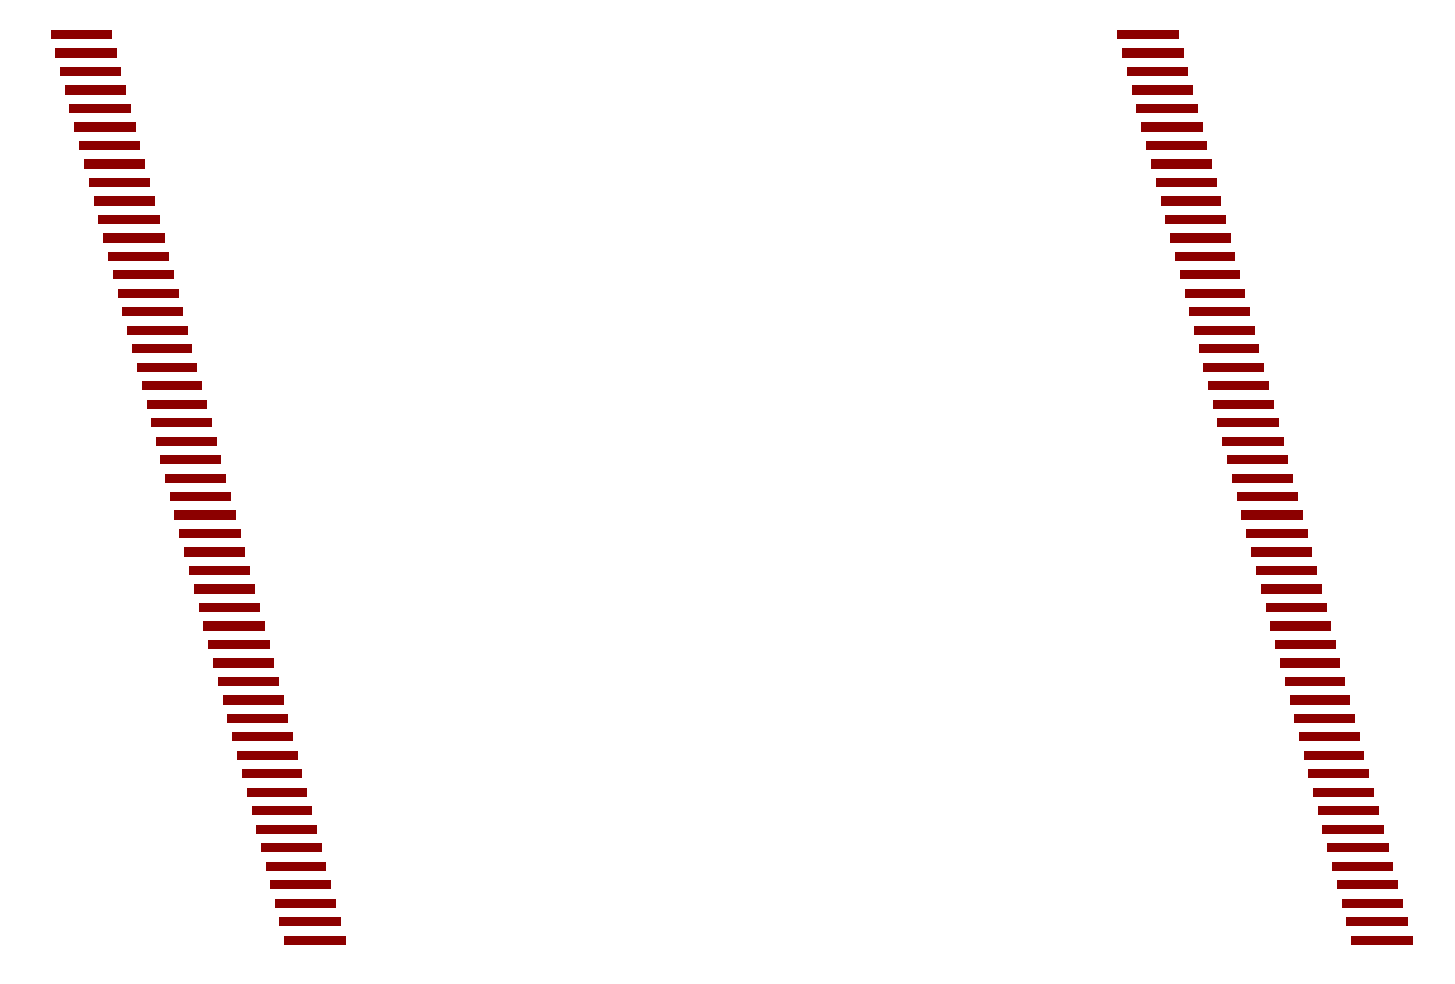

In [7]:

# Get the specific slices (rows) without boundary sites and only 50 elements out of 200

data_health =u_sol_health_bin[20, 4:54, :1700]

data_arr = u_sol_arr_bin[4:54, 20, :1700]

# Add blank rows between binary rows 
N1, T1 = data_arr.shape
gap1 = 1  # Gap size (number of blank rows)
data_health_with_blanks = np.zeros((N1 * (gap1 + 1), T1))
for i in range(N1):
    data_health_with_blanks[i * (gap1 + 1), :] = data_health[i, :]



gap2 = 1  # Gap size (number of blank rows)
data_arr_with_blanks = np.zeros((N1 * (gap2 + 1), T1))
for i in range(N1):
    data_arr_with_blanks[i * (gap2 + 1), :] = data_arr[i, :]
# Define a custom colormap: darkred for 1 and transparent for 0
colors = [(0, 0, 0, 0),  
          (0.55, 0, 0, 1)]  
cmap = ListedColormap(colors)



# Plot the data
plt.figure(figsize=(6,4), facecolor='none', dpi=300)

plt.imshow(data_health_with_blanks, cmap=cmap, interpolation='none',  aspect='auto', rasterized=True)
plt.xticks([])  
plt.yticks([]) 
#plt.ylabel("Excitable cells ", fontsize=16)
#plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.savefig('health_raster_row_healthy.pdf', **savefig_args)



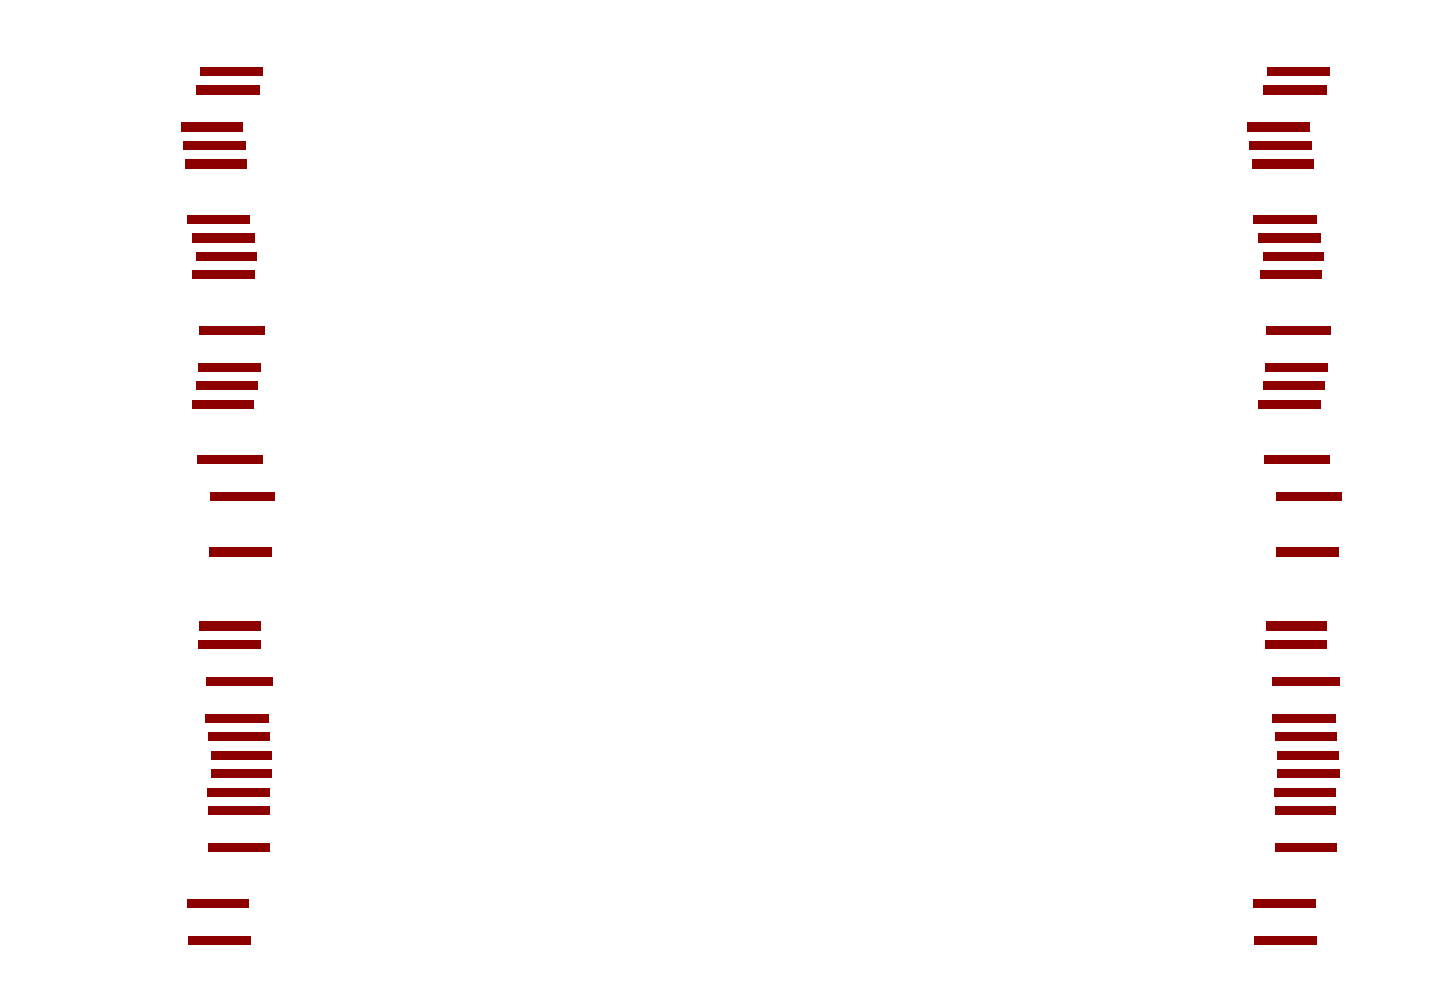

In [ ]:
plt.figure(figsize=(6, 4), facecolor='none', dpi=300)
plt.imshow(data_arr_with_blanks,cmap=cmap, interpolation='none', aspect='auto', rasterized=True)
plt.xticks([])  
plt.yticks([])  
#plt.ylabel("Excitable cells", fontsize=16)
#plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().set_rasterized(True)
plt.savefig('health_raster_row_arrhythmia.pdf', **savefig_args)
plt.show()



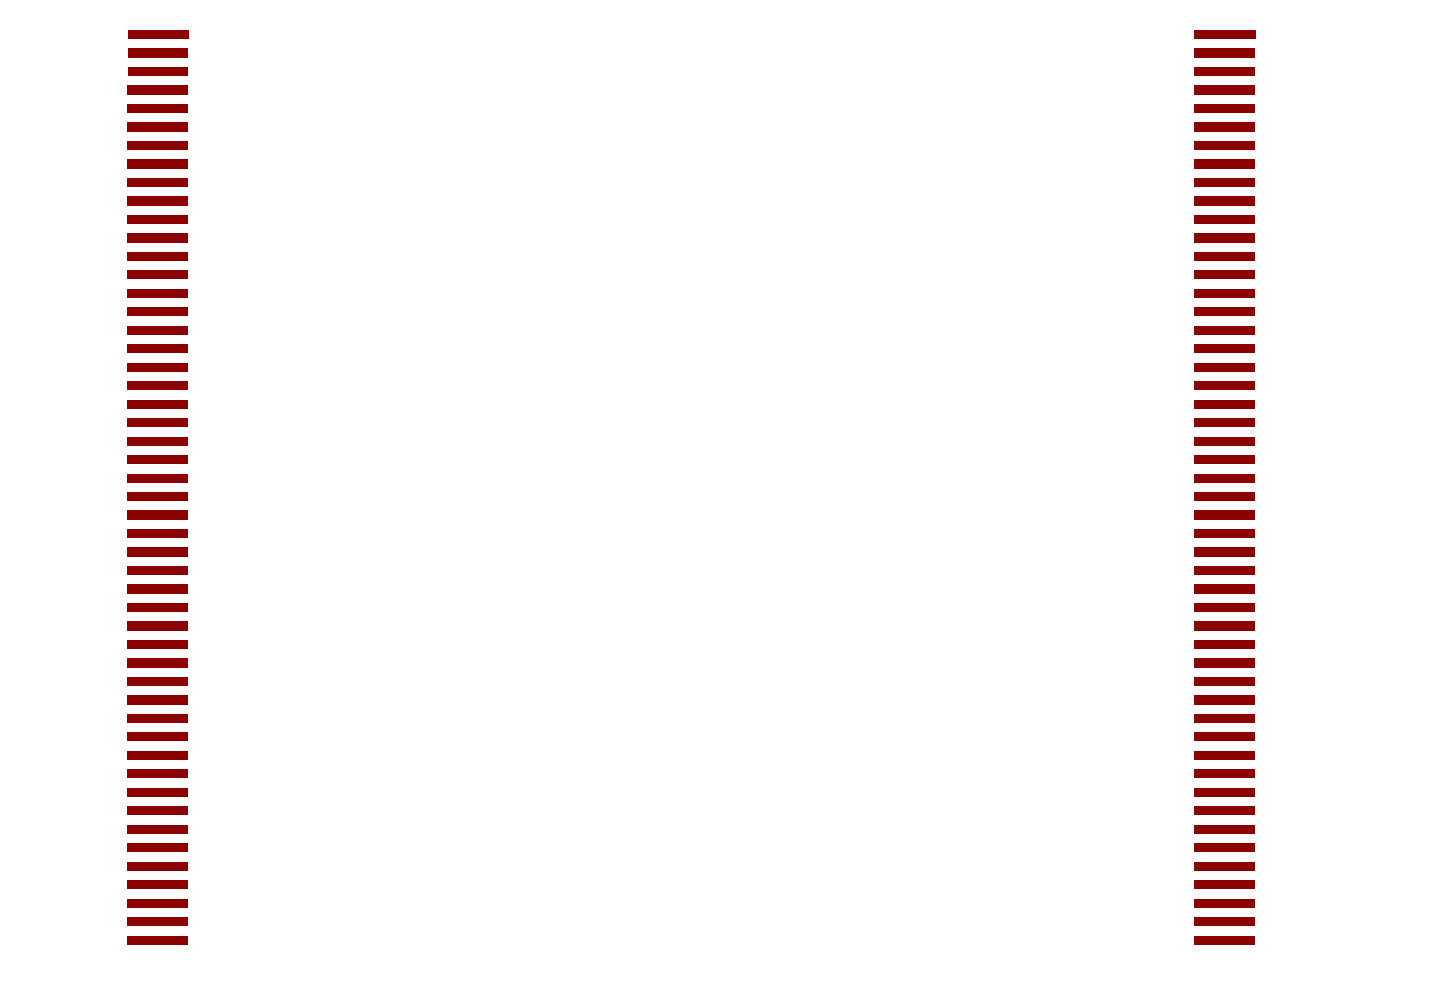

In [ ]:
# Get the specific slices (columns) without boundary sites

data_health = u_sol_health_bin[ 4:54,20, :1700]

data_arr = u_sol_arr_bin[4:54, 20, :1700]

# Add blank rows between binary rows 

gap1 = 1  # Gap size (number of blank rows)
data_health_with_blanks = np.zeros((N1 * (gap1 + 1), T1))
for i in range(N1):
    data_health_with_blanks[i * (gap1 + 1), :] = data_health[i, :]

# Add blank rows between binary rows 

gap2 = 1 
data_arr_with_blanks = np.zeros((N1 * (gap2 + 1), T1))
for i in range(N1):
    data_arr_with_blanks[i * (gap2 + 1), :] = data_arr[i, :]



# Plot the data
plt.figure(figsize=(6, 4), facecolor='none', dpi=300)
plt.imshow(data_health_with_blanks, cmap=cmap, interpolation='none', aspect='auto', rasterized=True)
plt.xticks([])  
plt.yticks([])  
#plt.ylabel("Excitable cells ", fontsize=16)
#plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)


plt.savefig('heart_raster_column_healthy.pdf', **savefig_args)




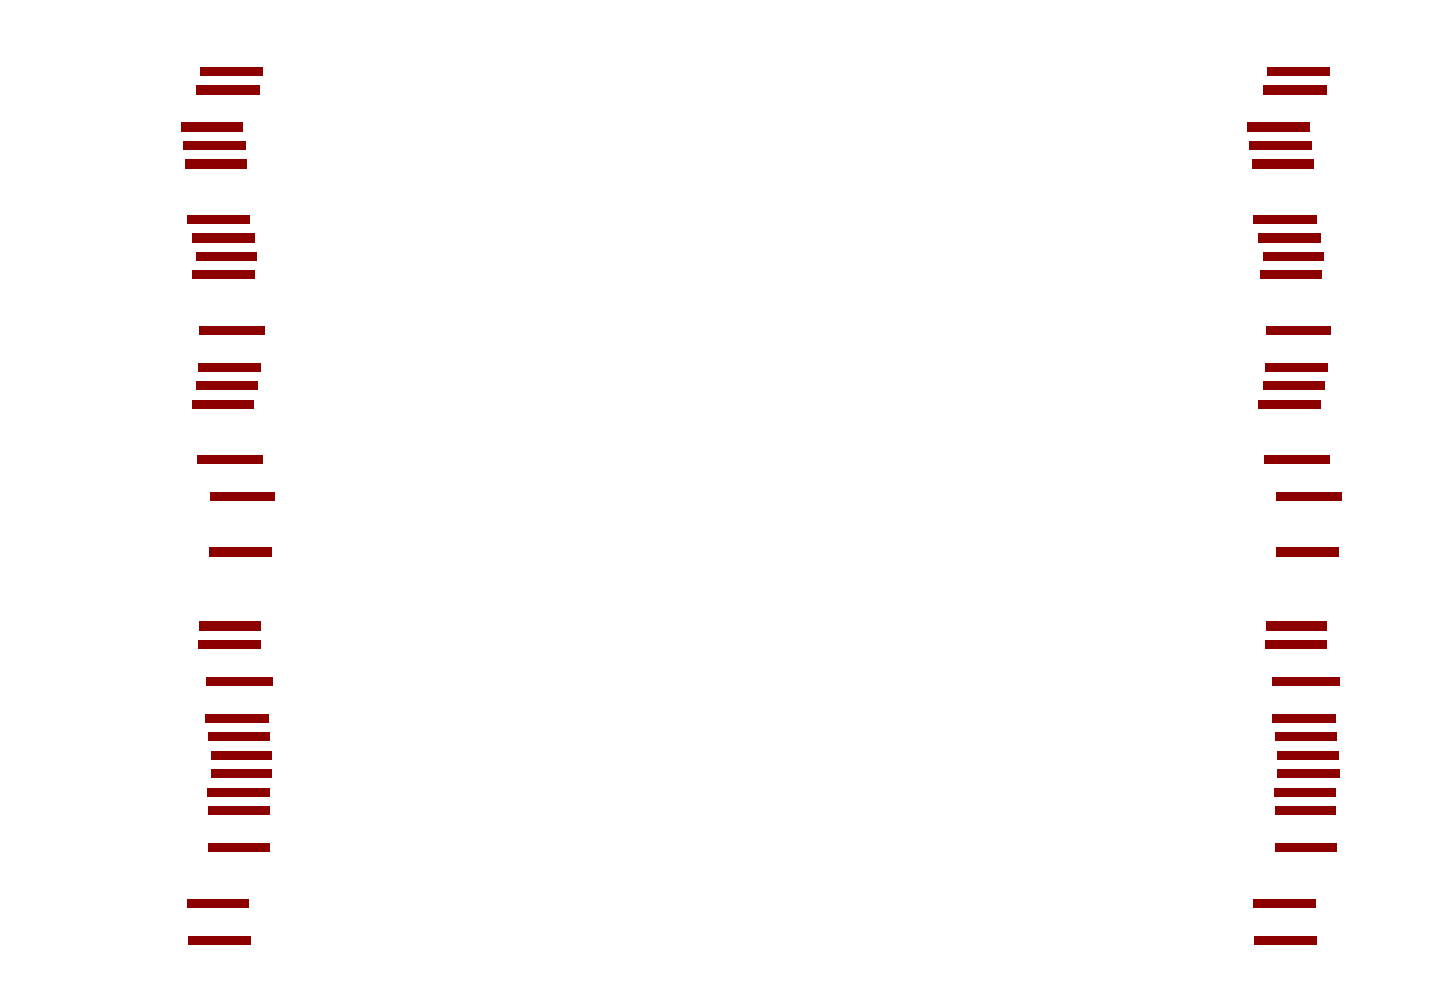

In [118]:
plt.figure(figsize=(6, 4), facecolor='none', dpi=300)
plt.imshow(data_arr_with_blanks, cmap=cmap, interpolation='none', aspect='auto', rasterized=True)
plt.xticks([])
plt.yticks([])  
#plt.ylabel("Excitable cells", fontsize=16)
#plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.savefig('heart_raster_column_arrhthmia.pdf', **savefig_args)
plt.show()


## ECG

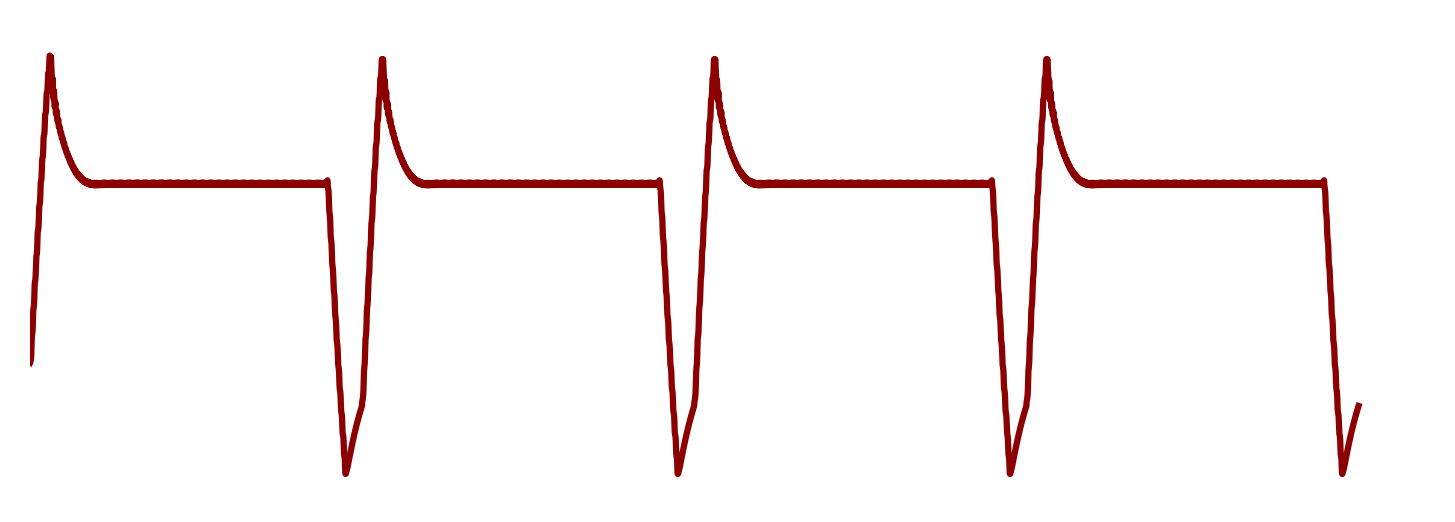

In [19]:
fig, ax = plt.subplots( figsize=(6, 2), facecolor='none', dpi=300)
u_sol_health=u_sol_health.reshape(N_y*N_x,-1)
#get the ECG
ECG=u_sol_health[ :, :].sum(axis=0)/10000
ax.plot(ECG, color='darkred', rasterized=True)    

#ax.set_xticks([0,2,4,6,8])
#ax.set_yticks([-0.9, 0,2])
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylim(-0.09,0.24)
ax.set_xlim(0)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.savefig('heart_ECG_p=0.45.pdf', **savefig_args)